Loading mapping from Data/attack2category_map.txt...
Successfully loaded 40 mappings.
Sample mapping: [('apache2', 'dos'), ('back', 'dos'), ('mailbomb', 'dos'), ('processtable', 'dos'), ('snmpgetattack', 'dos')]

Loading dataset from Data/network_connections.csv...
Dataset loaded. Shape: (125973, 42)
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    

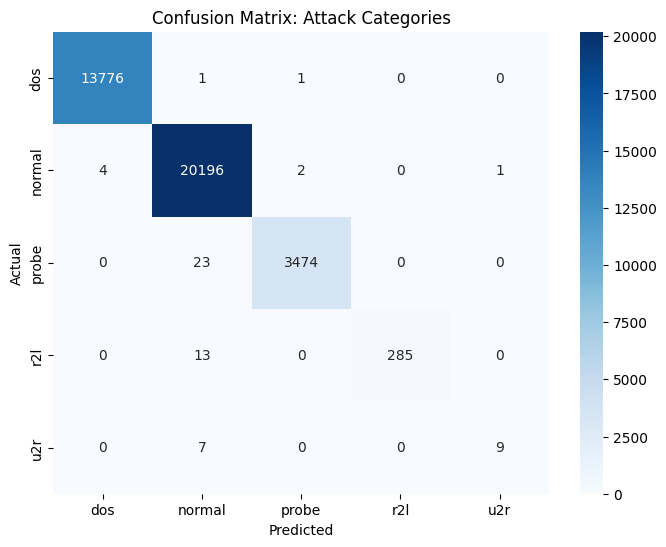

--- Training Model for Task 2 (Specific Attacks) ---
Task 2 (Advanced) Accuracy: 0.9984

Comparison:
Category Accuracy: 0.9986
Specific Accuracy: 0.9984
Difference: -0.0002

Classification Report (Specific Attacks - Top 15 classes):
                 precision    recall  f1-score  support
macro avg         0.834140  0.788852  0.801642  37792.0
weighted avg      0.998343  0.998439  0.998364  37792.0
normal            0.998023  0.999604  0.998813  20203.0
neptune           0.999919  0.999919  0.999919  12326.0
satan             0.997263  0.987353  0.992283   1107.0
ipsweep           0.997194  0.994403  0.995796   1072.0
portsweep         0.997732  0.992108  0.994912    887.0
smurf             1.000000  1.000000  1.000000    813.0
nmap              0.988453  0.993039  0.990741    431.0
back              0.996700  1.000000  0.998347    302.0
teardrop          1.000000  1.000000  1.000000    276.0
warezclient       1.000000  0.977099  0.988417    262.0
pod               1.000000  1.000000  1

/mnt/d/Software Projekte/Intellj/IdeaProjects/AIandSec_Project3/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/mnt/d/Software Projekte/Intellj/IdeaProjects/AIandSec_Project3/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/mnt/d/Software Projekte/Intellj/IdeaProjects/AIandSec_Project3/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sa

In [2]:
# %% [markdown]
# # AI & Security: Project 3 - Network Intrusion Detection
# **Student Name:** [Your Name]
#
# ## Project Overview
# This notebook builds a Network Intrusion Detection System (NIDS) using the provided dataset.
# We perform two classification tasks:
# 1. **Standard Task:** Classify connections into 4 attack categories + Normal (5 classes total).
# 2. **Advanced Task:** Predict the specific attack type (e.g., 'smurf', 'neptune').

# %%


# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# %% [markdown]
# ## 2. Load Data and Mappings
# We load the connection data and the attack-to-category mapping file from the 'Data' folder.

# %%
# Define file paths
DATA_DIR = 'Data'
CSV_FILE = os.path.join(DATA_DIR, 'network_connections.csv')
MAP_FILE = os.path.join(DATA_DIR, 'attack2category_map.txt')

# Standard KDD Cup 99 Column Names
# (Used if the CSV doesn't have a header. If it does, pandas will usually handle it,
# but explicit naming ensures safety for this specific dataset).
COL_NAMES = [
    "duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"
]

# --- Step A: Load the Mapping File ---
print(f"Loading mapping from {MAP_FILE}...")
attack_map = {}
try:
    with open(MAP_FILE, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                # Format: specific_attack category
                # Example: 'smurf dos'
                attack_map[parts[0]] = parts[1]

    # Ensure 'normal' is in the map
    if 'normal' not in attack_map:
        attack_map['normal'] = 'normal'

    print(f"Successfully loaded {len(attack_map)} mappings.")
    print("Sample mapping:", list(attack_map.items())[:5])

except FileNotFoundError:
    print("ERROR: Map file not found. Please check the path.")

# --- Step B: Load the Dataset ---
print(f"\nLoading dataset from {CSV_FILE}...")
try:
    # We assume no header based on standard KDD dumps, but if your CSV has one,
    # change header=None to header=0 and remove names=COL_NAMES
    df = pd.read_csv(CSV_FILE, header=0)

    # Clean label column (remove trailing periods if they exist, e.g. 'normal.')
    df['label'] = df['label'].astype(str).str.replace('.', '', regex=False)

    print(f"Dataset loaded. Shape: {df.shape}")
    print(df.head())
except FileNotFoundError:
    print("ERROR: CSV file not found. Please check the path.")

# %% [markdown]
# ## 3. Data Preprocessing
# * **Mapping:** Create the broad `category` column (DoS, Probe, etc.) from the specific `label`.
# * **Encoding:** Convert text features (`protocol_type`, `service`, `flag`) to numbers.

# %%
# 1. Apply Attack Category Mapping
df['category'] = df['label'].map(attack_map)

# Fill missing categories (if any label was not in the map file)
# We verify if any are missing
missing_cats = df[df['category'].isna()]['label'].unique()
if len(missing_cats) > 0:
    print(f"Warning: The following labels were not in the map file: {missing_cats}")
    df['category'] = df['category'].fillna('other')

print("\nClass Distribution (Categories):")
print(df['category'].value_counts())

# 2. Encode Categorical Features
# Columns that are strings need to be turned into numbers
categorical_cols = ['protocol_type', 'service', 'flag']

# Create a separate dataframe for processed data
X = df.drop(['label', 'category'], axis=1)
y_category = df['category']  # Target for Task 1
y_specific = df['label']     # Target for Task 2 (Advanced)

# Label Encoding
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# 3. Split Data
# We use one split for both tasks to ensure fair comparison
X_train, X_test, y_cat_train, y_cat_test, y_spec_train, y_spec_test = train_test_split(
    X, y_category, y_specific, test_size=0.3, random_state=42, stratify=y_category
)

# 4. Scaling (Optional for Random Forest, but included for completeness)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("\nData Split Complete.")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_train.shape[1]}")

# %% [markdown]
# ## Task 1: Standard Classification (5 Categories)
# Build a model to classify connections as: **Normal, DoS, Probe, R2L, or U2R**.

# %%
print("--- Training Model for Task 1 (Categories) ---")
clf_cat = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf_cat.fit(X_train, y_cat_train)

# Predictions
y_cat_pred = clf_cat.predict(X_test)

# Evaluation
acc_cat = accuracy_score(y_cat_test, y_cat_pred)
print(f"Task 1 Accuracy: {acc_cat:.4f}")

print("\nClassification Report (Categories):")
print(classification_report(y_cat_test, y_cat_pred))

# Visualization
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_cat_test, y_cat_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=clf_cat.classes_, yticklabels=clf_cat.classes_)
plt.title('Confusion Matrix: Attack Categories')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# %% [markdown]
# ## Task 2: Advanced Classification (Specific Attacks)
# Build a model to predict the specific attack name (e.g., 'smurf', 'warezclient').
# **Analysis:** We will compare the accuracy of this granular model against the category model.

# %%
print("--- Training Model for Task 2 (Specific Attacks) ---")
clf_spec = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf_spec.fit(X_train, y_spec_train)

# Predictions
y_spec_pred = clf_spec.predict(X_test)

# Evaluation
acc_spec = accuracy_score(y_spec_test, y_spec_pred)
print(f"Task 2 (Advanced) Accuracy: {acc_spec:.4f}")

print("\nComparison:")
print(f"Category Accuracy: {acc_cat:.4f}")
print(f"Specific Accuracy: {acc_spec:.4f}")
print(f"Difference: {acc_spec - acc_cat:.4f}")

print("\nClassification Report (Specific Attacks - Top 15 classes):")
# Limiting output size since there are many classes
report = classification_report(y_spec_test, y_spec_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose().sort_values(by='support', ascending=False).head(15)
print(report_df)

# %% [markdown]
# ### Analysis of Results
# * **Category Model:** Generally achieves high accuracy because the classes are broader and distinct (e.g., DoS vs Normal).
# * **Specific Model:** May have slightly lower overall accuracy or lower recall on "rare" attacks (like U2R subtypes) because there are very few training examples for them compared to massive attacks like 'smurf'.
# * **Conclusion:** While predicting the specific attack is harder, it provides much more actionable intelligence for security analysts.